# Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from tqdm import tqdm
import scipy.sparse as sp

import warnings
warnings.simplefilter('ignore')

from numpy.linalg import svd

from rectools.dataset import Dataset
from implicit.evaluation import mean_average_precision_at_k
from rectools.metrics.ranking import MAP
import scipy.sparse as scs

import os

In [3]:
us = os.getcwd()
us

'/Users/liliyaivannikova/Documents/project/git/RecSys_Films/recsyc_part1'

In [4]:
if 'liliyaivannikova' in us:
    PATH = r'/Users/liliyaivannikova/Documents/project/ml-latest/'
    movies = pd.read_csv(PATH + r'movies.csv')
    rating = pd.read_csv(PATH + r'ratings.csv')
elif 'Владислав' in us:
    movies = pd.read_csv(r'dataset/movies.csv')
    rating = pd.read_csv(r'dataset/ratings.csv')

In [5]:
print(f'''
movies: {movies.shape}
rating: {rating.shape}
''')


movies: (86537, 3)
rating: (33832162, 4)



In [6]:
movies.columns = [col.upper() for col in movies.columns]

movies['REALEASE'] = movies['TITLE'].str.extract("\((\d{4})\)", expand=True)
movies['REALEASE'] = pd.to_datetime(movies['REALEASE'], format='%Y')
movies['REALEASE'] = movies['REALEASE'].dt.year
movies['TITLE'] = movies['TITLE'].str[:-7]

In [7]:
movies['TITLE'] = movies['TITLE'].astype('category')
movies['REALEASE'] = movies['REALEASE'].astype('float16')
movies['GENRES'] = movies['GENRES'].str.replace('|', ',')

In [8]:
rating.columns = [col.upper() for col in rating.columns]
rating['TIMESTAMP'] = pd.to_datetime(rating['TIMESTAMP'], unit='s')

# Обработка полей

In [9]:
rating_stat = rating.groupby('USERID')['MOVIEID'].count().reset_index()
rating_stat['MOVIEID'].quantile(0.05)

3.0

In [10]:
#rating_stat['FLAG_05'] = np.where(rating_stat['MOVIEID'] > rating_stat['MOVIEID'].quantile(0.05), 1, 0)
rating_stat['FLAG_05'] = np.where(rating_stat['MOVIEID'] > 20, 1, 0)

In [11]:
rating = rating.merge(rating_stat[['USERID', 'FLAG_05']], how = 'left', on = 'USERID')

In [12]:
rating.head()

,USERID,MOVIEID,RATING,TIMESTAMP,FLAG_05
0,1,1,4.0,2008-11-03 17:52:19,1
1,1,110,4.0,2008-11-05 06:04:46,1
2,1,158,4.0,2008-11-03 17:31:43,1
3,1,260,4.5,2008-11-03 18:00:04,1
4,1,356,5.0,2008-11-03 17:58:39,1


In [13]:
# удаляем пропуски
rating = rating[~((rating.TIMESTAMP.isna())|(rating.USERID.isna())|(rating.RATING.isna()))]
# удаляем странного юзера
rating.query('USERID != 189614', inplace = True)
# удалим юзеров, у которых оценок меньше 3 (по 5 квантилю)
rating.query('FLAG_05 == 1', inplace = True)
print(rating.shape)

(32346391, 5)


# train-test split

In [14]:
rating.rename({'USERID':'user_id',
            'MOVIEID':'item_id',
            'RATING':'weight',
            'TIMESTAMP':'datetime'}, axis=1, inplace=True)

Разделим выборку на обучение и тест следующим образом: для каждого пользователя в тестовую выборку попадут 10 его последних оценок.

In [15]:
num_users, num_movies = rating['user_id'].nunique(), rating['item_id'].nunique()
num_users, num_movies

(198927, 81555)

In [16]:
user_df = pd.DataFrame(np.vstack((np.arange(1, num_users+1), rating['user_id'].unique())).T, 
                         columns= ['user_id_mod', 'user_id'])
item_df = pd.DataFrame(np.vstack((np.arange(1, num_movies+1), rating['item_id'].unique())).T, 
                         columns= ['item_id_mod', 'item_id'])

In [17]:
rating = rating.merge(user_df, how = 'left', on = 'user_id')
rating = rating.merge(item_df, how = 'left', on = 'item_id')

In [18]:
train_ratings, test_ratings = [], []
num_test_samples = 10

for userId, user_data in rating.groupby('user_id'):
    train_ratings += [user_data[:-num_test_samples]]
    test_ratings += [user_data[-num_test_samples:]]

train_ratings = pd.concat(train_ratings)
test_ratings = pd.concat(test_ratings)
train_ratings.shape, test_ratings.shape

((30357121, 7), (1989270, 7))

In [19]:
del rating

In [20]:
train_ratings.head(3)

,user_id,item_id,weight,datetime,FLAG_05,user_id_mod,item_id_mod
0,1,1,4.0,2008-11-03 17:52:19,1,1,1
1,1,110,4.0,2008-11-05 06:04:46,1,1,2
2,1,158,4.0,2008-11-03 17:31:43,1,1,3


In [23]:
def ALS(user_ids, item_ids, ratings, num_users, num_items, num_dims=32, num_iters=10, eps=1e-7):
    R = scs.coo_array((ratings, (user_ids, item_ids)), shape=(num_users, num_items)).tocsr()
    X = np.random.randn(num_users, num_dims) #U
    Y = np.random.randn(num_items, num_dims) #V
    
    for t in tqdm(range(num_iters)):
        RY = R @ Y
        for u in range(num_users):
            relevant_items = item_ids[user_ids == u]
            Y_rel = Y[relevant_items]
            YY = Y_rel.reshape(-1, num_dims, 1) * Y_rel.reshape(-1, 1, num_dims)
            X[u] = np.linalg.inv(YY.sum(axis=0) + eps * np.eye(num_dims)) @ RY[u]

        RX = R.T @ X
        for i in range(num_items):
            relevant_users = user_ids[item_ids == i]
            X_rel = X[relevant_users]
            XX = X_rel.reshape(-1, num_dims, 1) * X_rel.reshape(-1, 1, num_dims)
            Y[i] = np.linalg.inv(XX.sum(axis=0) + eps * np.eye(num_dims)) @ RX[i]
    
    return R, X, Y

R, X, Y = ALS(train_ratings['user_id_mod'], train_ratings['item_id_mod'], train_ratings['weight'], 
              num_users+1, num_movies+1, num_iters=10)

  0%|          | 0/10 [12:05:02<?, ?it/s]


KeyboardInterrupt: 

# Гиперпараметры, подбор

In [24]:
class KNN():

    def __init__(self, model = None, user_id = None):
        if model is None:
            self.model = ImplicitItemKNNWrapperModel(CosineRecommender(K=10))
        else:
            self.model = model
    
        self.user_id = user_id
    
    def fit(self, df_train):

        self.model.fit(df_train)

    def recommend(self, df_train, k):

        prediction = self.model.recommend(users = user_id, 
                                      dataset=df_train,
                                      k = k,
                                      filter_viewed = True
                                    )
        return prediction

In [25]:
user_ids = rating['user_id'].unique()

In [ ]:
mapk_list = list()
k_list = np.arange(2, 10, 2)

for k in tqdm(k_list):
    model = ImplicitItemKNNWrapperModel(CosineRecommender(K=k))  
    
    knn_model = KNN(model, user_ids)
    knn_model.fit(rating_dataset)
    reco = knn_model.recommend(rating_dataset, k=k)
    mapk_list.append(MAP(k=k).calc_per_user(reco, rating_dataset).mean())
    

  0%|          | 0/4 [00:00<?, ?it/s]

In [23]:
mapk_arr = np.array(mapk_list)*100

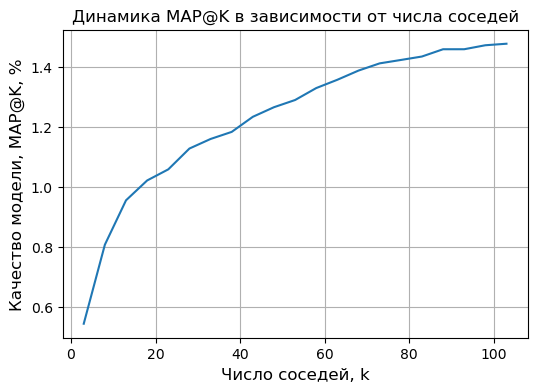

In [24]:
fig = plt.figure(figsize=(6,4))

plt.plot(k_list, mapk_arr, markersize=8)

plt.xlabel('Число соседей, k', fontsize=12)
plt.ylabel('Качество модели, MAP@K, %', fontsize=12)
plt.title('Динамика MAP@K в зависимости от числа соседей', fontsize=12)
plt.grid(True)
plt.savefig('knn_k.png')
plt.show()

In [25]:
model = ImplicitItemKNNWrapperModel(CosineRecommender(K=100))

knn_model = KNN(model, train_df)
knn_model.fit(train)
reco = knn_model.recommend(train, k=100)

In [33]:
MAP(k=100).calc_per_user(reco, test_df).mean()*100

1.4769547443490076

In [27]:
train_df.shape, test_df.shape

((33306949, 4), (491881, 4))

In [32]:
train_df['datetime'].min(), test_df['datetime'].max()

(Timestamp('1995-01-09 11:46:44'), Timestamp('2023-07-20 08:53:33'))